In [2]:
import numpy as np
import imageio.v3 as iio
import matplotlib.pyplot as plt
from mnist import MNIST
import tensorflow as tf
from tensorflow import keras


## DATA Preprocess

In [3]:
gt_im_path = "gt_im"
im = [iio.imread(gt_im_path+'/0.png'),
      iio.imread(gt_im_path+'/1.png'), 
      iio.imread(gt_im_path+'/2.png'),
      iio.imread(gt_im_path+'/3.png'),
      iio.imread(gt_im_path+'/4.png'),
      iio.imread(gt_im_path+'/5.png'),
      iio.imread(gt_im_path+'/6.png'),
      iio.imread(gt_im_path+'/7.png'),
      iio.imread(gt_im_path+'/8.png'),
      iio.imread(gt_im_path+'/9.png')
      ]

im = np.array(im)


## MNIST import

mndata = MNIST('samples')

images, labels = mndata.load_training()

images = np.array(images)
labels = np.array(labels)

gt_im = np.empty((60000,28,28))
for i in range(len(labels)):
    gt_im[i] = im[labels[i]]

#test set
Y_test = gt_im[0:10000]
Y_test = Y_test / 255.
X_test = images[0:10000]
X_test = X_test / 255.
X_test = X_test.reshape((X_test.shape[0],28,28))

#training set
Y_train = gt_im[10000:25000]
Y_train = Y_train / 255.
X_train = images[10000:25000]
X_train = X_train / 255.
X_train = X_train.reshape((X_train.shape[0],28,28))

## Model

In [7]:
## Unet block 


def encodeing_path(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def decoding_path(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

In [10]:
def UNet():
    f = [ 14, 28, 56]
    inputs = keras.layers.Input((28, 28, 1))
    
    p0 = inputs
    c1, p1 = encodeing_path(p0, f[0]) 
    c2, p2 = encodeing_path(p1, f[1]) 

    bn = bottleneck(p2, f[2])
    
    u1 = decoding_path(bn, c2, f[1]) 
    u2 = decoding_path(u1, c1, f[0]) 
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u2)
    model = keras.models.Model(inputs, outputs)
    return model

In [11]:
model = UNet()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
model.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_32 (Conv2D)             (None, 28, 28, 14)   140         ['input_3[0][0]']                
                                                                                                  
 conv2d_33 (Conv2D)             (None, 28, 28, 14)   1778        ['conv2d_32[0][0]']              
                                                                                                  
 conv2d_34 (Conv2D)             (None, 28, 28, 14)   1778        ['conv2d_33[0][0]']              
                                                                                            

In [6]:
epochs = 5
batch_size = 10

model.fit(X_train, Y_train, validation_data=(X_test, Y_test), steps_per_epoch=2000, validation_steps=100, epochs=epochs)

Epoch 1/5


2023-08-14 12:28:12.517895: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-14 12:28:12.737821: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.


2000/2000 [==============================] - ETA: 0s - loss: 0.0972 - acc: 0.8783

2023-08-14 12:30:13.006904: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2000/2000 [==============================] - 128s 62ms/step - loss: 0.0972 - acc: 0.8783 - val_loss: 0.0647 - val_acc: 0.8871
Epoch 2/5
2000/2000 [==============================] - 126s 63ms/step - loss: 0.0622 - acc: 0.8873 - val_loss: 0.0605 - val_acc: 0.8876
Epoch 3/5
2000/2000 [==============================] - 125s 63ms/step - loss: 0.0583 - acc: 0.8877 - val_loss: 0.0578 - val_acc: 0.8878
Epoch 4/5
2000/2000 [==============================] - 124s 62ms/step - loss: 0.0567 - acc: 0.8879 - val_loss: 0.0579 - val_acc: 0.8877
Epoch 5/5
2000/2000 [==============================] - 87s 44ms/step - loss: 0.0558 - acc: 0.8881 - val_loss: 0.0583 - val_acc: 0.8877


In [ ]:
model.save_weights("UNetW.h5")

## TEST

In [7]:
pred = model.predict(X_test)

2023-08-14 12:38:01.284629: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 11s 34ms/step


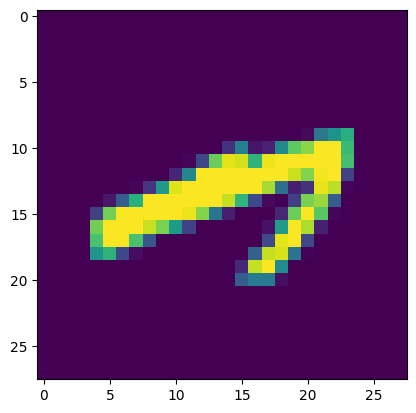

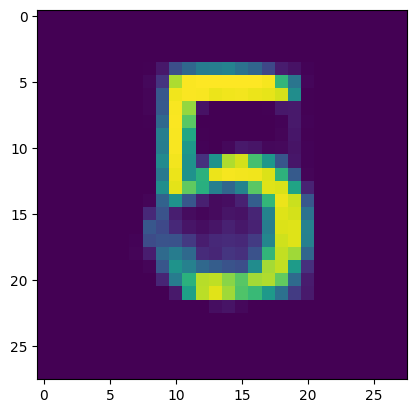

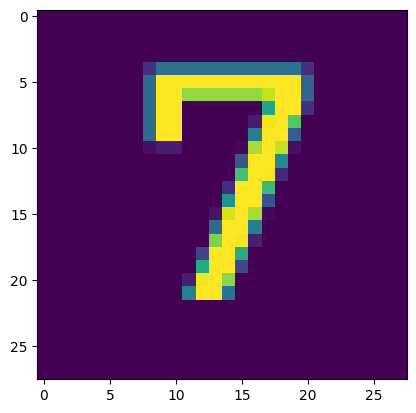

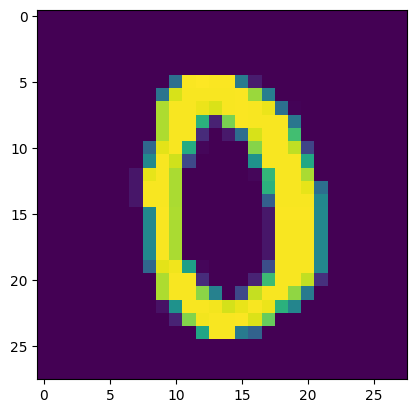

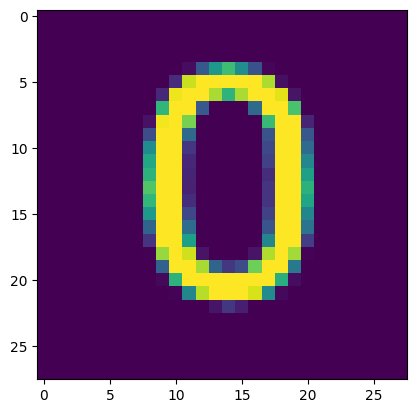

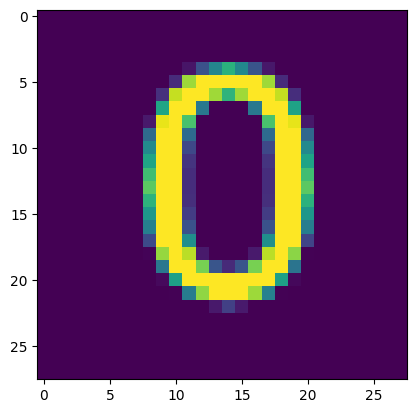

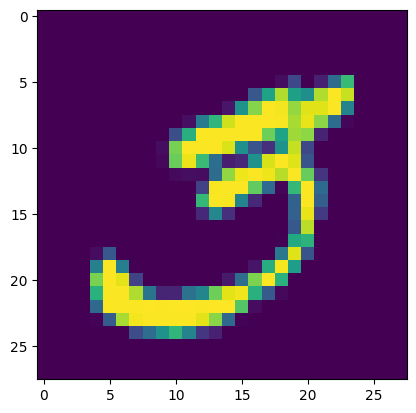

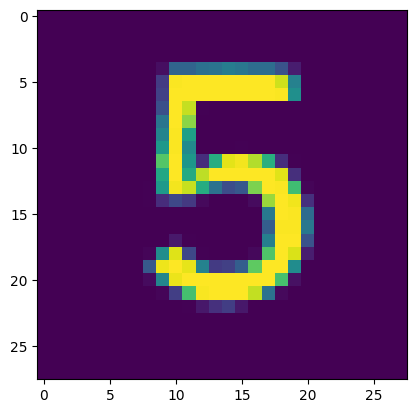

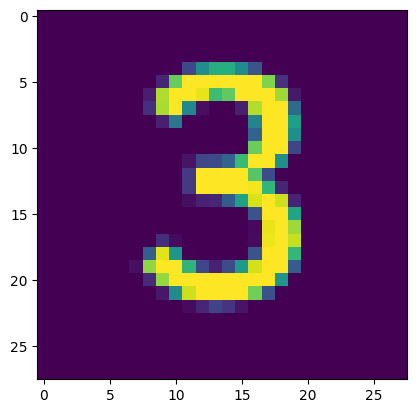

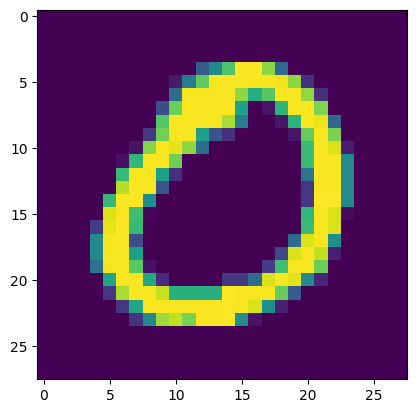

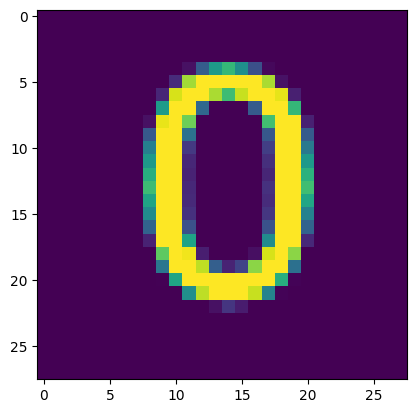

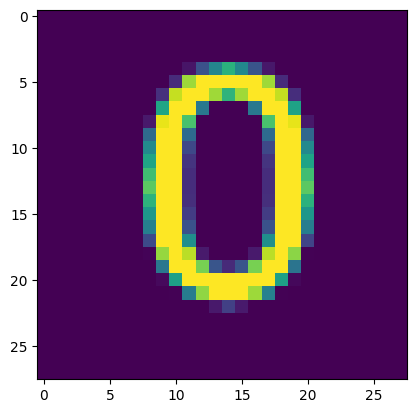

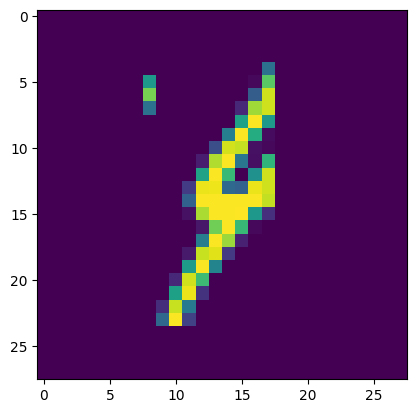

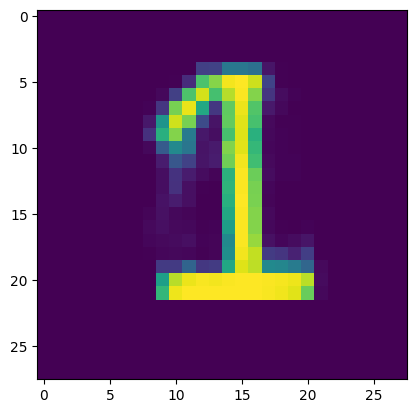

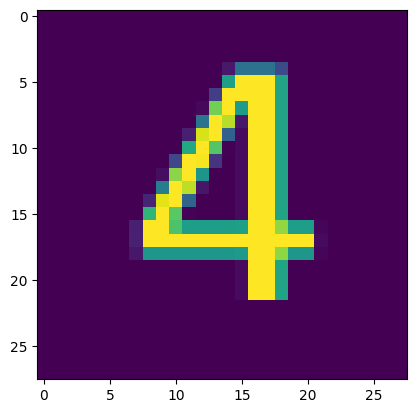

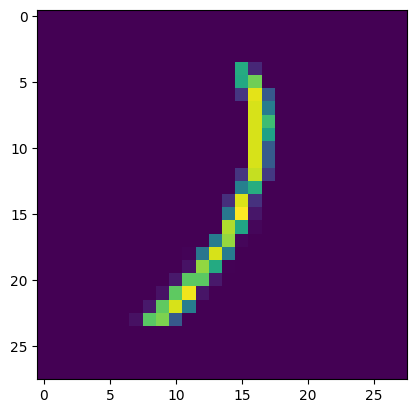

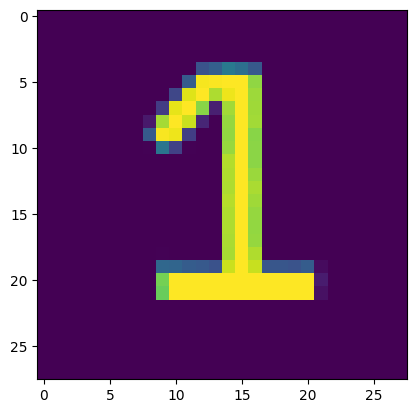

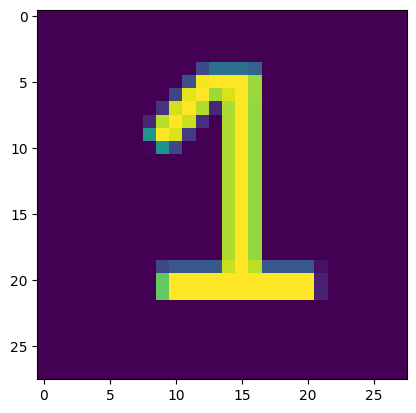

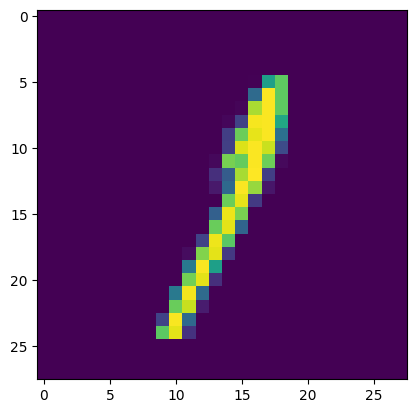

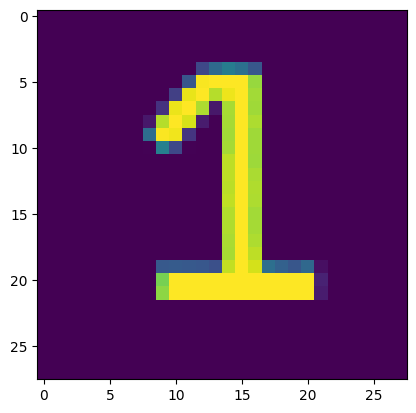

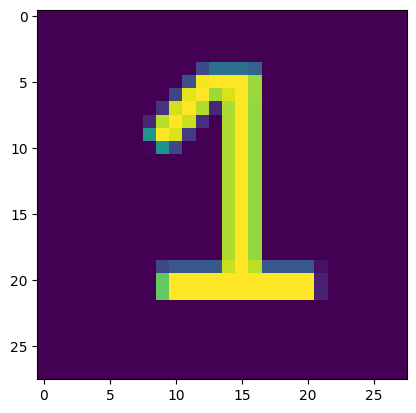

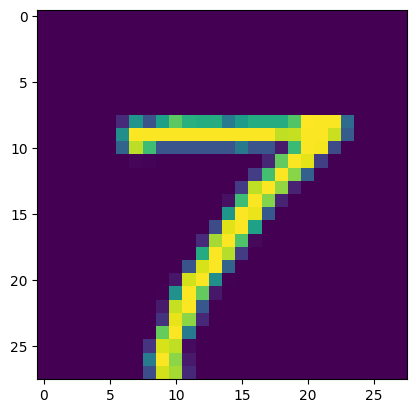

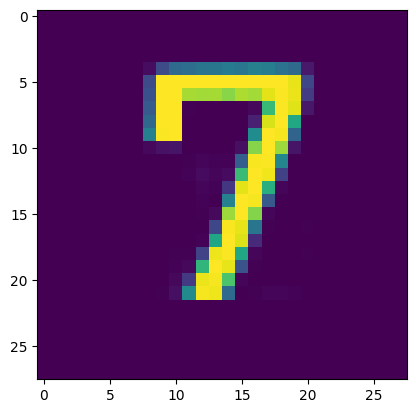

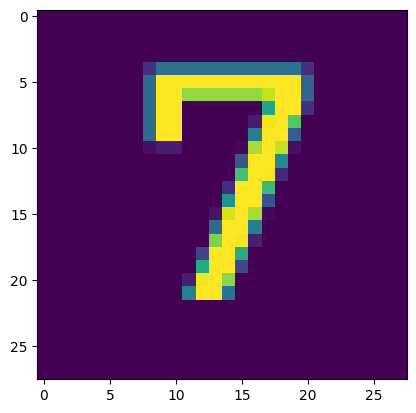

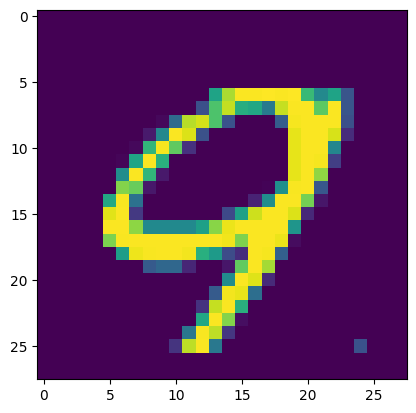

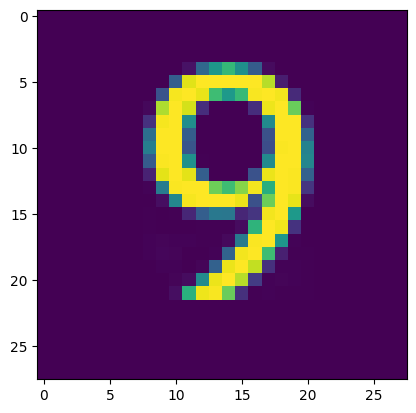

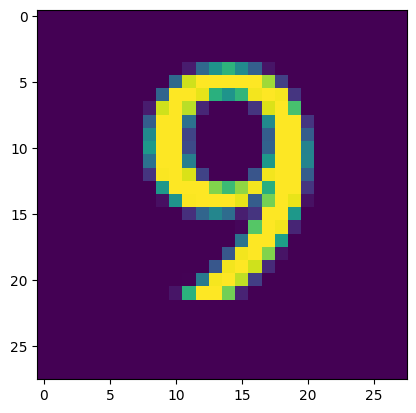

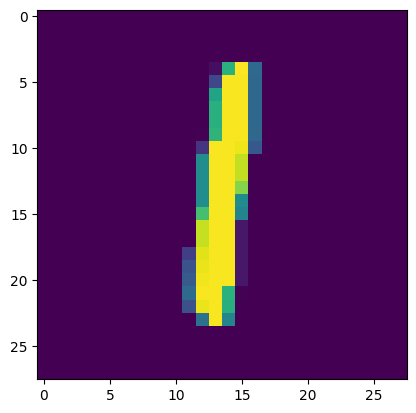

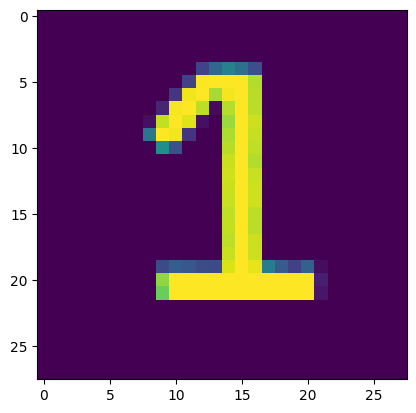

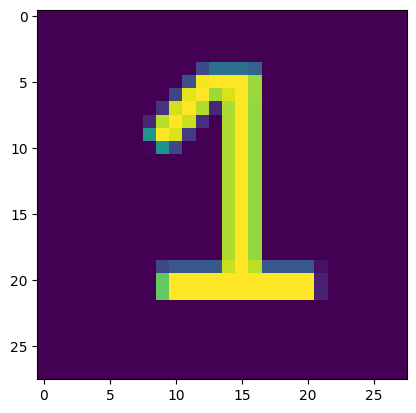

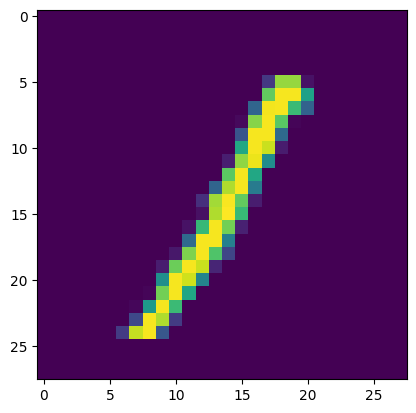

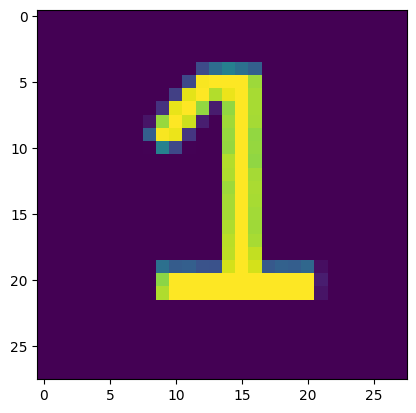

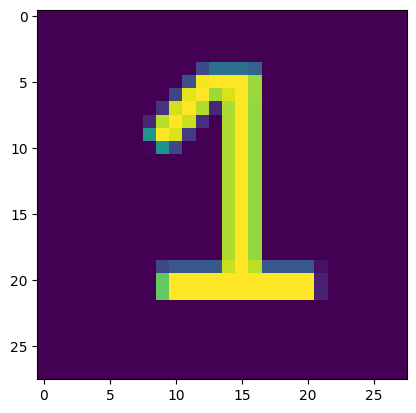

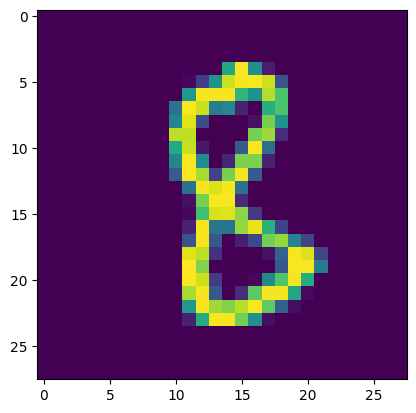

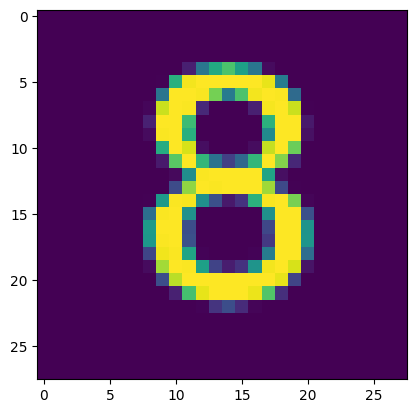

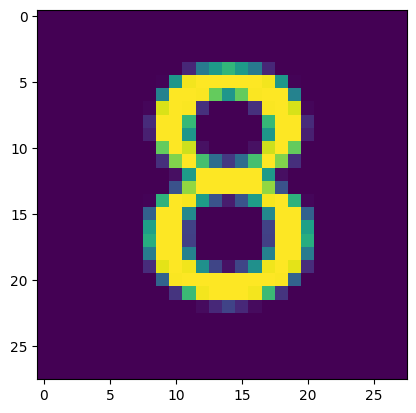

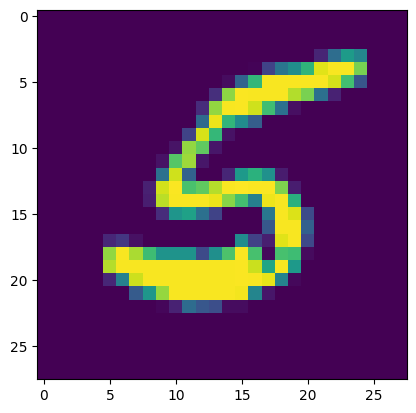

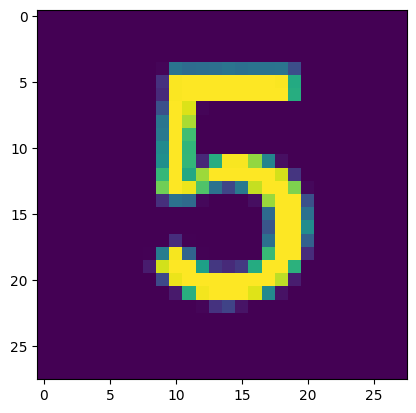

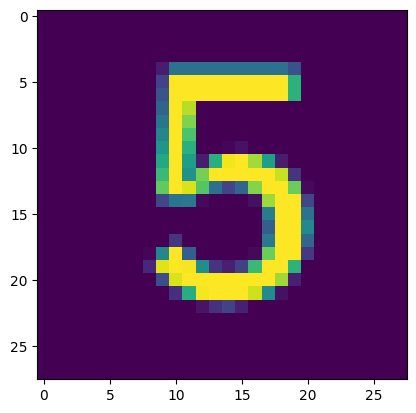

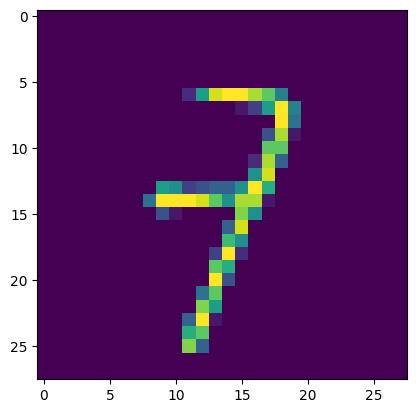

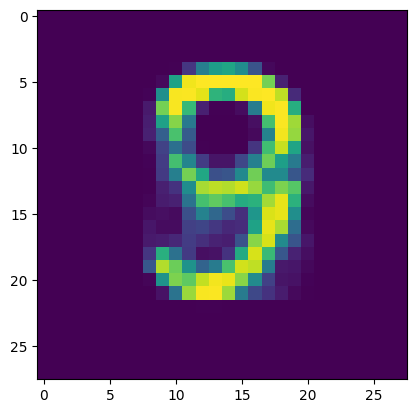

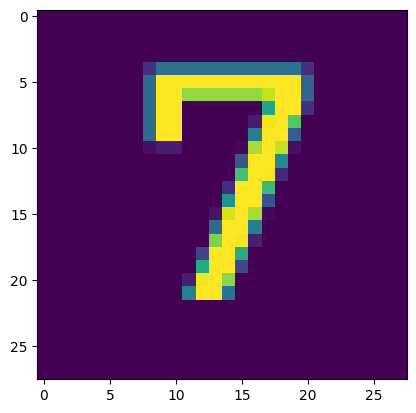

In [22]:
for i in range(1075,1089):
    
    plt.imshow(X_test[i])
    plt.show()
    plt.imshow(pred[i])
    plt.show()
    plt.imshow(Y_test[i])
    plt.show()